In [1]:
from argparse import ArgumentParser
from src.generate import _instatiate_minimagen
import numpy as np
import torch

from torch.utils.data import DataLoader

# Command line argument parser
parser = ArgumentParser()


parser.add_argument("-d", "--TRAINING_DIRECTORY", dest="TRAINING_DIRECTORY", help="Training directory to use for inference", type=str)
parser.add_argument("-b", "--BATCH_SIZE", dest="BATCH_SIZE", help="Batch size", default=128, type=int)
# args = parser.parse_args()
args = parser.parse_args(args=[])


In [2]:
dir_path = "/storage/baoshen/cardiff/cardiff_ldm_aug_coor/training_20250422_205636"
args.TRAINING_DIRECTORY = dir_path  
# /raid/baoshen/M3S_mobility_generation/cascaded_diffusion/cardiff_ldm/training_20250412_103851 

In [3]:
# minimagen = load_minimagen(args.TRAINING_DIRECTORY)

map_location = torch.device("cuda:0")

cardiff = _instatiate_minimagen(args.TRAINING_DIRECTORY)


denoisers_0 = "/storage/baoshen/cardiff/cardiff_ldm_aug_coor/training_20250422_205636/tmp/denoisers_0_449_tmp.pth"
# denoisers_0 = "/storage/baoshen/cardiff/cardiff_ldm_aug_dloss/training_20250422_153206/tmp/denoisers_0_329_tmp.pth"
denoisers_1 = "/storage/baoshen/cardiff/cardiff_ldm_aug_coor/training_20250422_205636/tmp/denoisers_1_449_tmp.pth"

cardiff.denoisers[0].load_state_dict(torch.load(denoisers_0, map_location=map_location))
cardiff.denoisers[1].load_state_dict(torch.load(denoisers_1, map_location=map_location))


/tmp/ipykernel_295111/2481999661.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cardiff.denoisers[0].load_state_dict(torch.load(denoisers_0, map_location=map_location)

<All keys matched successfully>

In [4]:
from torch.utils.data import random_split, TensorDataset, Dataset, DataLoader

import pandas as pd
import numpy as np

from transformers import (
    BertTokenizerFast,
    BartForConditionalGeneration,
    BartConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
)


def parse_sequence(seq):
    if isinstance(seq, str):
        return [int(x) for x in seq.strip().split()]
    elif isinstance(seq, list):
        return seq
    else:
        raise ValueError("unknown format")




class TrajectoryDataset(Dataset):
    def __init__(self, sequences, tokenizer, segment_coord_map, max_length=128):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.segment_coord_map = segment_coord_map

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx][:self.max_length]
        text = " ".join(str(x) for x in seq)
        lat = [self.segment_coord_map.get(x, (0.0, 0.0))[0] for x in seq]
        lon = [self.segment_coord_map.get(x, (0.0, 0.0))[1] for x in seq]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True,
            max_length=self.max_length, return_tensors="pt"
        )
        item = {key: encoding[key].squeeze(0) for key in encoding}
        item["lat"] = torch.tensor(lat + [0.0] * (self.max_length - len(lat)))
        item["lon"] = torch.tensor(lon + [0.0] * (self.max_length - len(lon)))
        item["labels"] = item["input_ids"].clone()
        return item

class CombinedDataset(Dataset):
    def __init__(self, tensor_dataset, token_dataset):
        assert len(tensor_dataset) == len(token_dataset), "两个数据集条数不一致！"
        self.tensor_dataset = tensor_dataset
        self.token_dataset = token_dataset

    def __len__(self):
        return len(self.tensor_dataset)

    def __getitem__(self, idx):
        trajs, heads, roads = self.tensor_dataset[idx]
        token_data = self.token_dataset[idx]
        combined_sample = {
            "trajs": trajs,
            "heads": heads,
            "roads": roads,
            "input_ids": token_data["input_ids"],
            "labels": token_data["labels"],
            "lat": token_data["lat"],
            "lon": token_data["lon"],
            "attention_mask": token_data.get("attention_mask", None)
        }
        return combined_sample




def custom_collate(batch):
    token_keys = {"input_ids", "labels", "attention_mask", "lat", "lon"}
    token_features = []
    other_features = {}

    for sample in batch:
        token_feat = {k: sample[k] for k in token_keys if k in sample}
        token_features.append(token_feat)
        for k, v in sample.items():
            if k not in token_keys:
                if k not in other_features:
                    other_features[k] = []
                other_features[k].append(v)

    for k in other_features:
        other_features[k] = torch.stack(other_features[k], dim=0)

    collated_tokens = data_collator(token_features)

    other_features.update(collated_tokens)
    return other_features

segment_df = pd.read_csv("/storage/baoshen/public_dataset/final_didi_train_segment_generation/edge_map_feature_chengdu.csv")
lat_min, lat_max = segment_df["lat"].min(), segment_df["lat"].max()
lon_min, lon_max = segment_df["lon"].min(), segment_df["lon"].max()
segment_df["norm_lat"] = 2 * (segment_df["lat"] - lat_min) / (lat_max - lat_min) - 1
segment_df["norm_lon"] = 2 * (segment_df["lon"] - lon_min) / (lon_max - lon_min) - 1
segment_coord_map = {
    int(row.edge_id): (row.norm_lat, row.norm_lon) for _, row in segment_df.iterrows()
}

roads = np.load('/storage/baoshen/public_dataset/final_didi_train_segment_generation/train_data/all_road_results.npy', allow_pickle=True)
trajs = np.load('/storage/baoshen/public_dataset/final_didi_train_segment_generation/train_data/all_traj_results.npy', allow_pickle=True)
heads = np.load('/storage/baoshen/public_dataset/final_didi_train_segment_generation/train_data/all_head_results.npy', allow_pickle=True)




trajs = trajs.transpose(0,2,1)
trajs = torch.from_numpy(trajs).float()

roads = roads.transpose(0, 2, 1)
roads = torch.from_numpy(roads).float()  # b * 64 * 2
heads = torch.from_numpy(heads).float()  # b * 128 * 2

tensor_dataset = TensorDataset(trajs, heads, roads)


file_path = "/storage/baoshen/public_dataset/final_didi_train_segment_generation/train_data/final_segments_all_train_data.pkl"
trajs_df = pd.read_pickle(file_path)

all_sequences = trajs_df['unique_id_seq'].apply(parse_sequence).tolist()
max_seq_length = 128

# 初始化tokenizer（请确保vocab_file存在且格式正确）
vocab_file = "/storage/baoshen/cardiff/cardiff_lm/pretrain_lm/bart_vocab.txt"
tokenizer = BertTokenizerFast(vocab_file=vocab_file, do_lower_case=False)
tokenizer.add_special_tokens({
    "bos_token": "<s>",
    "eos_token": "</s>",
    "pad_token": "<pad>",
    "mask_token": "<mask>",
    "unk_token": "<unk>"
})
token_dataset = TrajectoryDataset(all_sequences, tokenizer, segment_coord_map=segment_coord_map, max_length=max_seq_length)
data_collator = DataCollatorForSeq2Seq(tokenizer, padding="longest")

dataset = CombinedDataset(tensor_dataset, token_dataset)
total_size = len(dataset)

train_valid_size = int(0.9 * total_size)
test_size = total_size - train_valid_size

# train / test split
train_valid_dataset, test_dataset = random_split(dataset, [train_valid_size, test_size])


test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=128,
                                                shuffle=True,
                                                num_workers=1,
                                                collate_fn=custom_collate)



# 测试第一阶段生成，以及单独测试第二阶段的生成

In [5]:
import json
import os
import argparse
from auto_encoder.ft_latent_model import BARTForConditionalGenerationLatent
import torch
import re

parser = argparse.ArgumentParser()

device = torch.device("cuda:0")

latent_model_path = "/storage/baoshen/cardiff/cardiff_lm/latent_ae/saved_latent_models_l32d128_mask_coor/CD/2025-04-21_10-54-50"

with open(os.path.join(latent_model_path, 'args.json'), 'rt') as f:
    latent_model_args = json.load(f)

latent_argparse = argparse.Namespace(**latent_model_args)

args = latent_argparse
config = BartForConditionalGeneration.from_pretrained(
            latent_argparse.enc_dec_model).config

bart_model = BARTForConditionalGenerationLatent.from_pretrained(args.enc_dec_model, 
                                                          config=config, 
                                                          num_encoder_latents=args.num_encoder_latents,
                                                          num_decoder_latents=args.num_decoder_latents, 
                                                          dim_ae=args.dim_ae, 
                                                          num_layers=3,
                                                          l2_normalize_latents=args.l2_normalize_latents, 
                                                          _fast_init=False,
                                                          use_coords=args.use_coords)

data = torch.load(os.path.join(latent_model_path, 'model.pt'), map_location=device)
bart_model.load_state_dict(data['model'])

for (param_name, param) in bart_model.named_parameters():
    if re.fullmatch(".*perceiver.*", param_name):
        param.requires_grad = False
        print(f"Trainable: {param_name}")
    else:
        param.requires_grad = False



Some weights of BARTForConditionalGenerationLatent were not initialized from the model checkpoint at /storage/baoshen/cardiff/cardiff_lm/pretrain_lm/bart_pretrain_masked_4_2/checkpoint-45000 and are newly initialized: ['perceiver_ae.perceiver_decoder.final_norm.bias', 'perceiver_ae.perceiver_decoder.final_norm.weight', 'perceiver_ae.perceiver_decoder.input_proj.bias', 'perceiver_ae.perceiver_decoder.input_proj.weight', 'perceiver_ae.perceiver_decoder.layers.0.0.key_norm.gamma', 'perceiver_ae.perceiver_decoder.layers.0.0.norm.bias', 'perceiver_ae.perceiver_decoder.layers.0.0.norm.weight', 'perceiver_ae.perceiver_decoder.layers.0.0.query_norm.gamma', 'perceiver_ae.perceiver_decoder.layers.0.0.to_k.weight', 'perceiver_ae.perceiver_decoder.layers.0.0.to_out.bias', 'perceiver_ae.perceiver_decoder.layers.0.0.to_out.weight', 'perceiver_ae.perceiver_decoder.layers.0.0.to_q.weight', 'perceiver_ae.perceiver_decoder.layers.0.0.to_v.weight', 'perceiver_ae.perceiver_decoder.layers.0.1.0.bias', 'per

Trainable: perceiver_ae.perceiver_encoder.latents
Trainable: perceiver_ae.perceiver_encoder.pos_emb.emb.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.norm.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.norm.bias
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.norm_latents.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.norm_latents.bias
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.query_norm.gamma
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.key_norm.gamma
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.to_q.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.latent_to_kv.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.to_kv.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.to_out.0.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.0.to_out.0.bias
Trainable: perceiver_ae.perceiver_encoder.layers.0.1.0.weight
Trainable: perceiver_ae.perceiver_encoder.layers.0.1.0.bias
Trainable: percei

/tmp/ipykernel_295111/1972655569.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(latent_model_path, 'model.pt'), map_location=device)


### directly perform second-stage sampling

In [20]:
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=1024,
                                                shuffle=True,
                                                num_workers=1,
                                                collate_fn=custom_collate)

In [21]:
# mean = np.array([1.34658981, 103.83647051])
# std = np.array([0.04105782, 0.06231361])

images_list = []
cascaded_result_list = []
Gen_traj_results = []

for batch_num, batch in enumerate(test_dataloader):

    trajs = batch['trajs']  # traj
    heads = batch['heads']  # attr
    roads = batch['roads']  # road
    attention_mask = batch['attention_mask']
    input_ids=batch['input_ids']
    labels = batch['labels']

    sample_args={'cond_scale':3., "sampling_type":"ddim", "step":10}

    images, cascaded_results = cardiff.sample(text_embeds=heads, **sample_args)

    images_list.append(images)
    cascaded_result_list.append(cascaded_results)

    for i in range(len(images)):
        traj=images[i]
        # new_traj = traj.T * std + mean
        # Gen_traj_results.append(new_traj)
        Gen_traj_results.append(traj)
    
    break

/home/baoshen/miniconda3/envs/torch39/lib/python3.9/site-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789114325/work/torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
DDIM Sampling: 100%|██████████| 100/100 [34:39<00:00, 20.80s/it]
2it [37:12, 1116.38s/it]


In [22]:
cascaded_results[0].shape

torch.Size([1024, 32, 128])

In [23]:
cascaded_results[1].shape

torch.Size([1024, 2, 256])

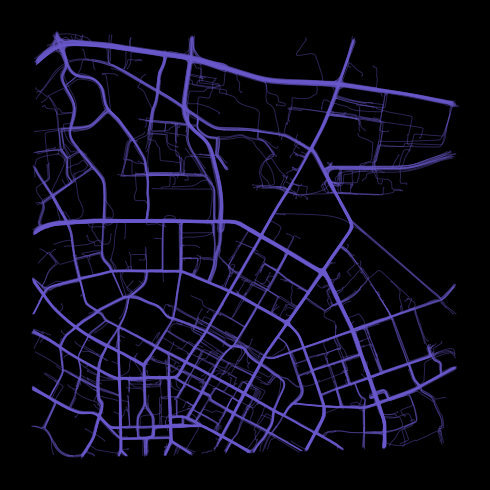

In [24]:
mean = np.array([30.68176148, 104.07740728])
std = np.array([0.01975033, 0.02220808])

import matplotlib.pyplot as plt

Gen_traj = []

plt.figure(figsize=(5, 5), facecolor='black')  # 设置画布背景为黑色
ax = plt.gca()
# ax.set_facecolor('black')  # 设置坐标区域背景为黑色
# 移除边框
# for spine in ax.spines.values():
#     spine.set_visible(False)

# 关闭坐标轴
plt.axis('off')

# xlim = [104.02, 104.14]  # 经度范围
# ylim = [30.62, 30.74]    # 纬度范围
# plt.xlim(xlim)
# plt.ylim(ylim)

for i in range(len(images[:1024])):
    traj=images[i]
    new_traj = traj.T * std + mean
    Gen_traj.append(new_traj)
    # plt.plot(new_traj[:,1],new_traj[:,0],color='red', linewidth=0.7, alpha=0.3)
    plt.plot(new_traj[:,1],new_traj[:,0],color='slateblue', linewidth=0.7, alpha=0.4)
plt.tight_layout()

plt.savefig('tmp0.pdf')
plt.show()

In [25]:
images.shape

torch.Size([1024, 2, 256])

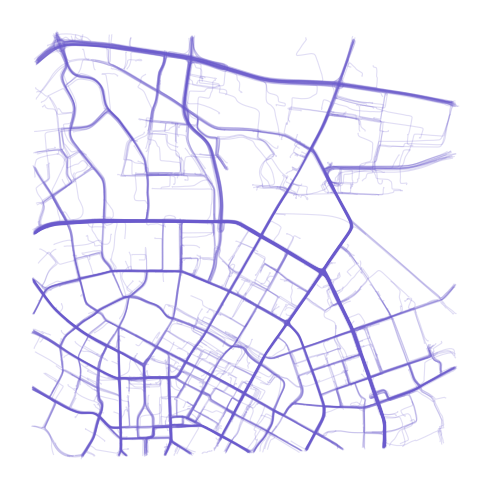

In [26]:
mean = np.array([30.68176148, 104.07740728])
std = np.array([0.01975033, 0.02220808])

import matplotlib.pyplot as plt

Gen_traj = []

plt.figure(figsize=(5, 5), facecolor='white')  # 设置画布背景为黑色
ax = plt.gca()
# ax.set_facecolor('black')  # 设置坐标区域背景为黑色
# 移除边框
# for spine in ax.spines.values():
#     spine.set_visible(False)

# 关闭坐标轴
plt.axis('off')

# xlim = [104.02, 104.14]  # 经度范围
# ylim = [30.62, 30.74]    # 纬度范围
# plt.xlim(xlim)
# plt.ylim(ylim)

for i in range(len(images[:1024])):
    traj=images[i]
    new_traj = traj.T * std + mean
    Gen_traj.append(new_traj)
    # plt.plot(new_traj[:,1],new_traj[:,0],color='red', linewidth=0.7, alpha=0.3)
    plt.plot(new_traj[:,1],new_traj[:,0],color='slateblue', linewidth=0.8, alpha=0.2)
plt.tight_layout()

# plt.savefig('tmp2.pdf')
plt.show()

In [ ]:
# print(len(Gen_traj))
# Gen_traj_array = np.array(Gen_traj)

# np.save('/storage/baoshen/trajectory_evaluation/CD/CD-cascaded-sdn-Gen-traj-array.npy', Gen_traj_array)
# Gen_traj_array.shape

1024


(1024, 256, 2)

In [37]:
trajs.shape

torch.Size([1024, 2, 256])

In [38]:
t_trajs = trajs.permute(0, 2, 1)
ori_traj = t_trajs* std+mean
ori_traj = ori_traj.cpu().numpy()  
np.save('/storage/baoshen/trajectory_evaluation/CD/CD-cascaded-sdn-Gen-real-traj-array.npy', ori_traj)
ori_traj.shape

(1024, 256, 2)